In [6]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms

In [7]:
cudnn.benchmark = True

In [8]:
!rm -R data/sloths_versus_pain_au_chocolat/train/.ipynb_checkpoints
!rm -R data/sloths_versus_pain_au_chocolat/val/.ipynb_checkpoints

# To make sure that the deletion has occurred
!ls data/sloths_versus_pain_au_chocolat/train/ -a   

rm: data/sloths_versus_pain_au_chocolat/train/.ipynb_checkpoints: No such file or directory
rm: data/sloths_versus_pain_au_chocolat/val/.ipynb_checkpoints: No such file or directory
ls: -a: No such file or directory
ls: data/sloths_versus_pain_au_chocolat/train/: No such file or directory


In [9]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [14]:
# Provide data directory
data_dir = '/Users/louisvsbigmac/Documents/Coding/ML Image Database'

# Create image folders for our training and validation data 
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

# Obtain dataset sizes from image_datasets
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# Obtain class_names from image_datasets
class_names = image_datasets['train'].classes

# Use image_datasets to sample from the dataset
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True)
              for x in ['train', 'val']}

In [15]:
# Change selected device to CUDA, a parallel processing platform, if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [16]:
def imshow(inp, title=None):
    """
    This function will make use of Matplotlib.pyplot's imshow() function for tensors. 
    It will show the same number of images as the batch we defined.
    """
    # The transpose is required to get the images into the correct shape
    inp = inp.numpy().transpose((1, 2, 0)) 

    # Using default values for mean and std but can customize
    mean = np.array([0.485, 0.456, 0.406]) 
    std = np.array([0.229, 0.224, 0.225])
    
    # To visualize the correct colors     
    inp = std * inp + mean
    
    # To view a clipped version of an image             
    inp = np.clip(inp, 0, 1)
    
    # Visualize inp
    plt.imshow(inp)
    
    if title is not None: # Plot title goes here
        plt.title(title)
    plt.pause(0.001)  # Enables the function to pause while the plots are updated


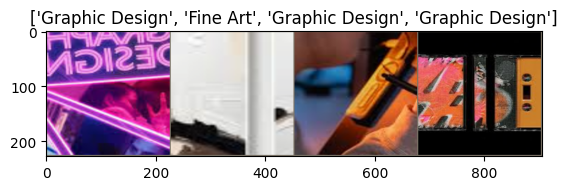

In [17]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

# Plot the grid with a title that concatenates all the class labels
imshow(out, title=[class_names[x] for x in classes])    

In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    '''
    Function that will train model based on data provided.
    '''
    
    since = time.time()

    # Make a deep copy of the model provided     
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data using the dataloader we defined
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass, tracking history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimization only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Computing loss statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Create a deep copy of the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print() # Print an empty line for nice formatting

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load the best model weights
    model.load_state_dict(best_model_wts)
    return model

In [19]:
def visualize_model(model, num_images=6):
    '''
    Function that will visualize results of the model
    '''
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [20]:
# Load the resnet model
model_ft = models.resnet18(pretrained=True)

# Obtaining the number of input features for our final layer
num_ftrs = model_ft.fc.in_features

# Since this is a binary classification task, we'll set the size of each output sample to 2. For multi-class classification, this can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

# Move the model to the device
model_ft = model_ft.to(device)

# We'll use CrossEntropyLoss(), which is a common loss function for classification problems
criterion = nn.CrossEntropyLoss()

# In this step, we'll optimize all parameters of the model
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# We'll decay learning rate (lr) by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
# Call our train_model() function with the ResNet model, the criterion, optimizer, learning rate scheduler, and number of epochs that we have defined.
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/opt/homebrew/lib/python3.11/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.7506 Acc: 0.6815
val Loss: 0.4594 Acc: 0.8000

Epoch 1/24
----------
train Loss: 0.6641 Acc: 0.7179
val Loss: 0.7172 Acc: 0.8000

Epoch 2/24
----------
train Loss: 0.6882 Acc: 0.7126
val Loss: 1.2175 Acc: 0.5828

Epoch 3/24
----------
train Loss: 0.6745 Acc: 0.7198
val Loss: 0.4590 Acc: 0.8038

Epoch 4/24
----------
train Loss: 0.5884 Acc: 0.7323
val Loss: 0.4903 Acc: 0.7936

Epoch 5/24
----------
train Loss: 0.6067 Acc: 0.7505
val Loss: 0.4972 Acc: 0.8038

Epoch 6/24
----------
train Loss: 0.6249 Acc: 0.7280
val Loss: 0.4456 Acc: 0.8311

Epoch 7/24
----------
train Loss: 0.4538 Acc: 0.8027
val Loss: 0.4289 Acc: 0.8483

Epoch 8/24
----------
train Loss: 0.4204 Acc: 0.8151
val Loss: 0.4599 Acc: 0.8300

Epoch 9/24
----------
train Loss: 0.4192 Acc: 0.8166
val Loss: 0.4604 Acc: 0.8273

Epoch 10/24
----------
train Loss: 0.3867 Acc: 0.8295
val Loss: 0.4623 Acc: 0.8327

Epoch 11/24
----------
train Loss: 0.3900 Acc: 0.8300
val Loss: 0.4522 Acc: 0.8386

Epoch 12/24
----------
t

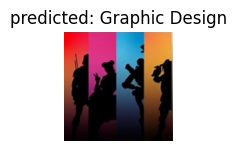

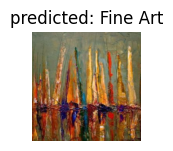

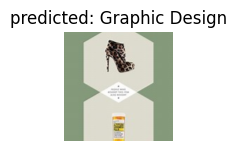

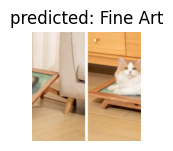

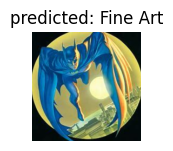

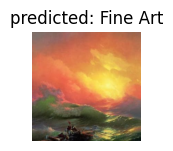

In [24]:
visualize_model(model_ft)